# Library imports

In [1]:
import pandas as pd
import matplotlib.ticker as tick
import matplotlib.pylab as plt
import seaborn as sns

from util.reformat_large_tick_values import reformat_large_tick_values
from sqlalchemy.engine import create_engine

In [2]:
engine = create_engine('bigquery://', credentials_path= 'key/iowa-liquor-sales-365322-12ff7a5498e6.json')

In [12]:
sns.set(font_scale = 1.4)
colors = ['#1f77b4', '#9467bd', '#e377c2', '#17becf', '#2ca02c', '#bcbd22', '#FFEB3B', '#FFA000', '#d62728', '#873600']
county_colors = sns.color_palette(colors)
sns.color_palette(county_colors)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (1.0, 0.9215686274509803, 0.23137254901960785),
 (1.0, 0.6274509803921569, 0.0),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5294117647058824, 0.21176470588235294, 0.0)]

# Data imports

In [3]:
census_data_df = pd.read_csv('data/census_data.csv')
census_data_df

,county,population,percent_minors
0,POLK,492401,0.245
1,LINN,230299,0.228
2,SCOTT,174669,0.235
3,JOHNSON,152854,0.197
4,BLACK HAWK,131144,0.220
5,WOODBURY,105941,0.262
6,DUBUQUE,99266,0.227
7,STORY,98537,0.164
8,DALLAS,99678,0.269
9,POTTAWATTAMIE,93667,0.234


In [8]:
Compare total liters sold by county

KeyboardInterrupt: 

In [11]:
county_liters_sold_sql_statement = """
WITH 
source_table AS (
  SELECT
    volume_sold_liters,
    date,
    store_number,
    county,
    EXTRACT(YEAR FROM date) AS year
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE EXTRACT(YEAR FROM date) IN (2018, 2019, 2020, 2021, 2022, 2023)
  ),

store_county_map AS ( 
  SELECT 
    store_number,
    MAX(county) AS county
  FROM source_table
  WHERE store_number IS NOT NULL
  GROUP BY store_number
  ),

joined_table AS (
  SELECT a.volume_sold_liters, a.date, a.year, COALESCE(a.county, b.county) AS county
  FROM source_table a
  LEFT JOIN store_county_map b ON a.store_number = b.store_number
  ),

cleaned_source_table AS (
  SELECT 
    volume_sold_liters,
    date,
    year,
    county
  FROM joined_table
  WHERE county IN ("POLK", "LINN", "SCOTT", "JOHNSON", "BLACK HAWK", "WOODBURY", "DUBUQUE", "STORY", "DALLAS", "POTTAWATTAMIE")
  )

SELECT 
    county,
    SUM(volume_sold_liters) AS liters_sold 
FROM cleaned_source_table
GROUP BY county 
ORDER BY liters_sold DESC
  """.strip()

liters_per_county_df = pd.read_sql_query(county_liters_sold_sql_statement, engine)
liters_per_county_df

,county,liters_sold
0,POLK,29930652.23
1,LINN,12167698.73
2,SCOTT,9396626.76
3,JOHNSON,7721792.78
4,BLACK HAWK,7397299.17
5,POTTAWATTAMIE,4919518.66
6,WOODBURY,4714513.44
7,STORY,4275882.30
8,DUBUQUE,4272910.42
9,DALLAS,3558796.90


# Visual feature exploration

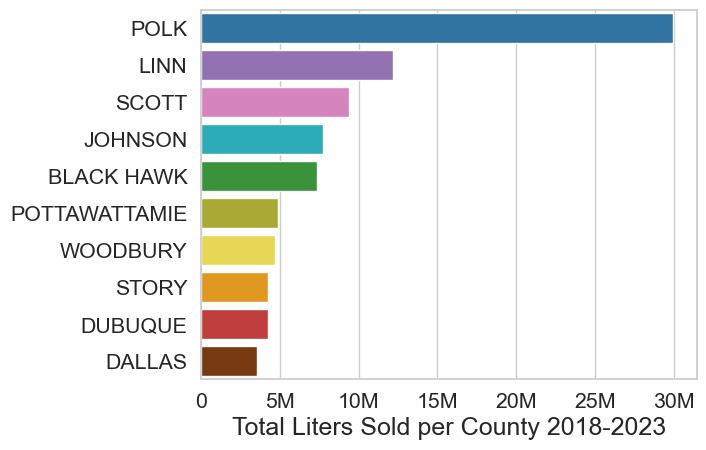

In [14]:
sns.barplot(x = 'liters_sold', y = 'county', data= liters_per_county_df,  palette= county_colors)
ax = plt.gca()
ax.set_xlabel("Total Liters Sold per County 2018-2023" , size = 18)
#ax.set_ylabel('Iowa Counties', size = 18)
ax.set_ylabel(None)
#ax.set_title("Liquor Liters Sold 2018-2021", size = 20)
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
sns.axes_style("ticks")
sns.set_style("whitegrid")
plt.savefig('liquor_liters_sold.png', transparent= True, bbox_inches='tight', pad_inches=0)

Use Iowa liquor sales data to visualize total sales per county per year over target six year period.

In [28]:
sales_by_county_year_sql_statement = """
WITH 
source_table AS (
  SELECT
    volume_sold_liters,
    date,
    store_number,
    county,
    CAST(EXTRACT(YEAR FROM date) AS string) AS year
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE EXTRACT(YEAR FROM date) IN (2018, 2019, 2020, 2021, 2022, 2023)
  ),

store_county_map AS ( 
  SELECT 
    store_number,
    MAX(county) AS county
  FROM source_table
  WHERE store_number IS NOT NULL
  GROUP BY store_number
  ),

joined_table AS (
  SELECT a.volume_sold_liters, a.date, a.year, COALESCE(a.county, b.county) AS county
  FROM source_table a
  LEFT JOIN store_county_map b ON a.store_number = b.store_number
  ),

cleaned_source_table AS (
  SELECT 
    volume_sold_liters,
    date,
    year,
    county
  FROM joined_table
  WHERE county IN ("POLK", "LINN", "SCOTT", "JOHNSON", "BLACK HAWK", "WOODBURY", "DUBUQUE", "STORY", "DALLAS", "POTTAWATTAMIE")
  )

SELECT
    sum(volume_sold_liters) AS liters_sold,
    year,
    county
FROM cleaned_source_table
GROUP BY county, year 
ORDER BY year
""" .strip()

sales_by_county_year_df = pd.read_sql_query(sales_by_county_year_sql_statement, engine)
sales_by_county_year_df

,liters_sold,year,county
0,1184783.97,2018,BLACK HAWK
1,670742.38,2018,STORY
2,4699225.52,2018,POLK
3,764404.84,2018,POTTAWATTAMIE
4,1228588.56,2018,JOHNSON
5,1490333.41,2018,SCOTT
6,1946474.43,2018,LINN
7,430210.91,2018,DALLAS
8,730983.19,2018,WOODBURY
9,710385.99,2018,DUBUQUE


In [29]:
sales_by_county_year_df['county'] = sales_by_county_year_df['county'].str.title()

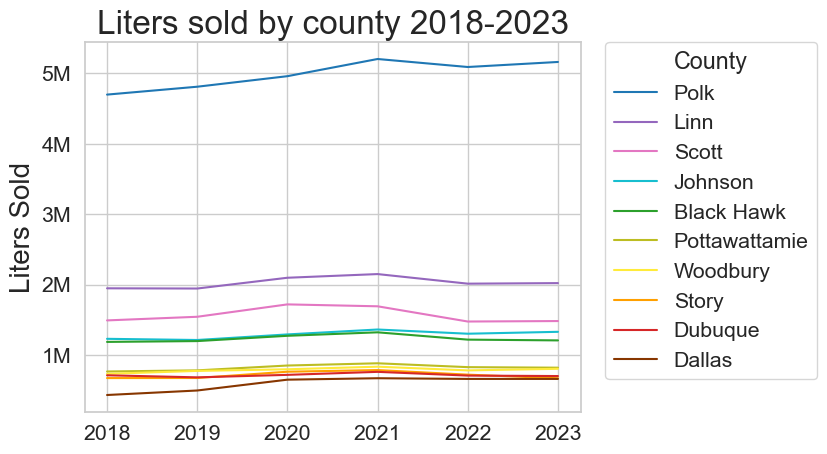

In [30]:
sns.lineplot(data = sales_by_county_year_df, x = 'year', y = 'liters_sold', hue= 'county', palette= county_colors,
hue_order = [
    "Polk","Linn","Scott","Johnson","Black Hawk","Pottawattamie","Woodbury","Story","Dubuque","Dallas"
         ])
ax5  = plt.gca()
ax5.set(xlabel=None)
ax5.set_ylabel( "Liters Sold" , size = 20 )
ax5.set_title( "Liters sold by county 2018-2023", size = 24 )
ax5.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
plt.legend(title = 'County', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

# Statistical methods to identify relationship strengths

In [ ]:
#Pearsons correlation coefficients